## Section 02: Pre-Flop Equity
**Abstract**: This notebook estimates the equity of different hands in Texas Hold'em poker at the Pre-Flop stage of the game using a Monte Carlo simulation approach. It processes a previously generated dataset of poker hands and engineers features that can be used to group similar hands. Then it calculates the frequency that certain types of hands will win, a useful approximation of equity. These equity approximations are saved as a dataframe for future use.

In [1]:
# Imports
import numpy as np
import pandas as pd
from deuces import Card

**Preflop Equity Calculation**: We estimate preflop equity by grouping hands based on their rank combinations and suitedness, and then calculating the frequency of winning for each group for various amounts of players. This is done by considering all possible opponent combinations and counting the number of times a hand wins at showdown based on showdown order and number of players.

In [2]:
# load long-form dataframe
hands_long = pd.read_pickle('../data/hands_long.pkl')

# remove all unnecessary columns, we are only interested in the player's hole cards and showdown order
preflop_hands = hands_long[[
    'hole_', 'showdown_order_'
]].copy()
# preview data
preflop_hands.head()

,hole_,showdown_order_
0,"[533255, 67144223]",2
1,"[4212241, 164099]",4
2,"[268454953, 8394515]",5
3,"[8406803, 8398611]",4
4,"[16787479, 279045]",8


In [3]:
# we are less concerned with the exact hole cards, and more concerned with the rank combinations and
# suitedness because these features will allow us to group similar hands together
# add columns that represent the rank set (frozenset of two ranks) and suitedness
preflop_hands['rank_set'] = preflop_hands['hole_'].apply(
    lambda cards: frozenset([Card.get_rank_int(card) for card in cards])
)
preflop_hands['suited'] = preflop_hands['hole_'].apply(
    lambda cards: Card.get_suit_int(cards[0]) == Card.get_suit_int(cards[1])
)
preflop_hands = preflop_hands.drop(columns=['hole_'])
# preview data
preflop_hands.head()

,showdown_order_,rank_set,suited
0,2,"(10, 3)",False
1,4,"(1, 6)",False
2,5,"(12, 7)",False
3,4,(7),False
4,8,"(8, 2)",False


In [4]:
# create a dataframe that represents all the possible preflop conditions to account for, like number of
# players, rank combinations, and suitedness
rows = []
for players in range(2,10): # number of players from 2 to 9 (includes self)
    for r1 in range(13): # rank 0 to 12 (2 to A)
        for r2 in range(13): # rank 0 to 12 (2 to A)
            rows.append({
                'players': players,
                'rank_set': frozenset([r1, r2]), # use frozenset to ignore order and easy comparisons
                'suited': r1 < r2, # suited if r1 < r2 (e.g., (A, K) is suited, (K, A) is not)
            })
preflop_conditions = pd.DataFrame(rows)
# preview data
preflop_conditions.head()

,players,rank_set,suited
0,2,(0),False
1,2,"(0, 1)",True
2,2,"(0, 2)",True
3,2,"(0, 3)",True
4,2,"(0, 4)",True


In [5]:
# merge the two dataframes to get all combinations preflop features and number of players
preflop_hands = preflop_hands.merge(
    preflop_conditions,
    on=['rank_set', 'suited'],
)
# we should have 900k * 8 = 7.2 million rows now
preflop_hands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200000 entries, 0 to 7199999
Data columns (total 4 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   showdown_order_  int64 
 1   rank_set         object
 2   suited           bool  
 3   players          int64 
dtypes: bool(1), int64(2), object(1)
memory usage: 171.7+ MB


To calculate the number of times a hand would win at showdown given its showdown order $O \in [1,9]$ and number of players $P \in [2,9]$, as well as the total number of hands to consider for $P$ players, we can use combinatorial mathematics.

When trying to determine how many hands we need to consider for $P$ players, we can think of it as choosing $P-1$ opponents from the 8 total opponents (since one player is the target). Thus, the total number of hands to consider for $P$ players is given by:
$$
\text{total hands} = \binom{8}{P-1}
$$
When trying to determine how many times a hand would win at showdown given its showdown order $O$ and number of players $P$, there are $9-O$ players with worse showdown order (9 total players - O players with less than or equal showdown order). We need to choose $P-1$ opponents from these $9-O$ players. Thus, the number of times a hand would win at showdown is given by:
$$
\text{wins} = \binom{9 - O}{P-1}
$$
These methods are defined in the functions `total_hands` and `wins` which belong to the `src.helpers` module.

In [6]:
from src.helpers import total_hands, wins

# add columns that represent the total number of hands to consider for P players, and the number of times
# the hand won (showdown_order_ is minimum compared to a combination of P-1 other players)

preflop_hands['total_hands'] = preflop_hands['players'].apply(total_hands)

preflop_hands['wins'] = preflop_hands[['showdown_order_','players']].apply(
    lambda row: wins(row['showdown_order_'], row['players']),
    axis=1
)
# preview data
preflop_hands.head()

,showdown_order_,rank_set,suited,players,total_hands,wins
0,2,"(10, 3)",False,2,8,7
1,2,"(10, 3)",False,3,28,21
2,2,"(10, 3)",False,4,56,35
3,2,"(10, 3)",False,5,70,35
4,2,"(10, 3)",False,6,56,21


In [7]:
# aggregate to get total wins and total hands for each condition
preflop_equity = preflop_hands.groupby(
    ['players', 'rank_set', 'suited']
).agg(
    total_wins=('wins', 'sum'),
    total_hands=('total_hands', 'sum'),
).reset_index()
# compute win frequency
preflop_equity['win_freq'] = preflop_equity['total_wins'] / preflop_equity['total_hands']
# preview data
preflop_equity.head()

,players,rank_set,suited,total_wins,total_hands,win_freq
0,2,(3),False,19608,32024,0.612291
1,2,"(6, 7)",False,33645,66792,0.503728
2,2,"(6, 7)",True,11518,22024,0.522975
3,2,"(12, 6)",False,40294,65280,0.617249
4,2,"(12, 6)",True,14346,22728,0.631204


In [8]:
# save preflop_equity dataframe
preflop_equity.to_pickle('../data/preflop_equity.pkl')

In [9]:
# convert rankset to separate columns to allow csv export
def split_rankset(row):
    if row['suited']:
        return pd.Series(sorted(list(row['rank_set']), reverse=True))
    elif len(row['rank_set']) == 2:
        return pd.Series(sorted(list(row['rank_set'])))
    else:
        return pd.Series([list(row['rank_set'])[0], list(row['rank_set'])[0]])

preflop_equity[['r1', 'r2']] = preflop_equity.apply(split_rankset, axis=1)
preflop_equity = preflop_equity.drop(columns=['rank_set'])
# preview data
preflop_equity.head()

,players,suited,total_wins,total_hands,win_freq,r1,r2
0,2,False,19608,32024,0.612291,3,3
1,2,False,33645,66792,0.503728,6,7
2,2,True,11518,22024,0.522975,7,6
3,2,False,40294,65280,0.617249,6,12
4,2,True,14346,22728,0.631204,12,6


Here is a table found online that shows the true equity of various preflop hands. We can visualize our estimated preflop equity as a heatmap and compare it to to this table to see how well our estimates match up.

![preflop_equity_table](https://static.seekingalpha.com/uploads/2023/2/17/saupload_Screen-Shot-2020-05-25-at-12.00.45-PM.png)

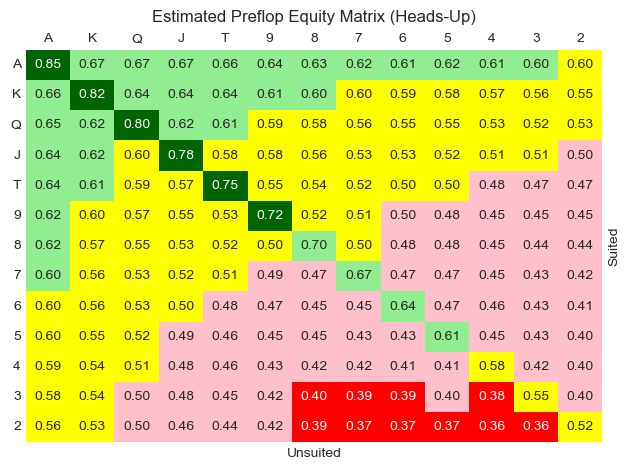

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

preflop_equity_matrix = np.zeros((13, 13)) # heads-up equity matrix 13x13 ranks (2 to A)

for r1 in range(13):
    for r2 in range(13):
        suited = r1 > r2
        row = preflop_equity[
            (preflop_equity['players'] == 2) &
            (preflop_equity['r1'] == r1) &
            (preflop_equity['r2'] == r2)
        ]
        preflop_equity_matrix[r1, r2] = row['win_freq'].values[0]


preflop_equity_matrix = np.rot90(preflop_equity_matrix, 2)

labels = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']

bins = [0, 0.4, 0.5, 0.6, 0.7, 1]
colors = ['red', 'pink', 'yellow', 'lightgreen', 'darkgreen']  # use hex for light pink
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, cmap.N)

fig, ax = plt.subplots()
sns.heatmap(
    preflop_equity_matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    norm=norm,
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    ax=ax
)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel("Unsuited")
ax.xaxis.set_label_position('bottom')
ax.set_ylabel("Suited")
ax.yaxis.set_label_position('right')
plt.yticks(rotation=0),
linecolor='white',
linewidth=1,
ax.tick_params(axis='both', length=0)  # removes tick lines

plt.title("Estimated Preflop Equity Matrix (Heads-Up)", pad=20)

plt.tight_layout()
plt.savefig('../figures/preflop_equity_matrix.png')
plt.show()

**Conclusion**: The estimated Pre-Flop equity matrix closely aligns with known values, validating the Monte Carlo simulation approach. This matrix can be a valuable tool for players to make informed decisions during the Pre-Flop stage of Texas Hold'em poker, as well as a look-up table for poker AI models. The same methodology can be extended to estimate equity at later stages of the game, such as the Flop, Turn, and River, by incorporating community cards into the simulation.